In [ ]:
%cd /content/drive/MyDrive/22CS3073_BTP/GANs-Practical

/content/drive/MyDrive/22CS3073_BTP/GANs-Practical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [ ]:
def psnr(target, ref):

    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# MSE
def mse(target, ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [ ]:
# Preparing Images by resizing
cwd = os.getcwd()
def prepare_images(path, factor):

    for file in os.listdir(path):
        try:
          img = cv2.imread(path + '/' + file)

          h, w, _ = img.shape
          new_height = int(h / factor)
          new_width = int(w / factor)

          img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

          img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

          print('Saving {}'.format(file))
          cv2.imwrite('images/{}'.format(file), img)
        except:
          print('ERROR for file-', file, '!')
          pass

prepare_images('source/', 2)

Saving download.jpeg
Saving Ankur_LR.jpg


In [ ]:


def compare_images(target, ref):
    if target.shape != ref.shape:
        raise ValueError("Input images must have the same dimensions.")

    mse_value = np.mean((target - ref) ** 2)

    if mse_value == 0:
        psnr_value = float('inf')  # Perfect match
    else:
        psnr_value = 20 * np.log10(255.0 / np.sqrt(mse_value))

    win_size = min(7, target.shape[0], target.shape[1])
    ssim_value = ssim(target, ref, multichannel=True, win_size=win_size, channel_axis=-1)

    return psnr_value, mse_value, ssim_value

for file in os.listdir('images/'):
    try:
        target_path = os.path.join('images', file)
        ref_path = os.path.join('source', file)

        target = cv2.imread(target_path)
        ref = cv2.imread(ref_path)

        if target is None or ref is None:
            print(f"Error loading {file}. Ensure both source and target images exist.")
            continue

        if target.shape != ref.shape:
            target = cv2.resize(target, (ref.shape[1], ref.shape[0]))

        psnr_value, mse_value, ssim_value = compare_images(target, ref)

        print(f"{file}\nPSNR: {psnr_value:f}\nMSE: {mse_value:f}\nSSIM: {ssim_value:f}\n")

    except Exception as e:
        print(f"Error processing {file}: {e}")



Error loading .ipynb_checkpoints. Ensure both source and target images exist.
download.jpeg
PSNR: 33.765151
MSE: 27.325319
SSIM: 0.926598

Ankur_LR.jpg
PSNR: 39.813461
MSE: 6.787882
SSIM: 0.979267



In [ ]:
# SRCNN Model
def model():

    SRCNN = Sequential()

    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    # optimizer
    adam = Adam(lr=0.0003)

    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN


In [ ]:
srcnn = model()
srcnn.summary()

ValueError: Argument(s) not recognized: {'lr': 0.0003}

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Degraded Image: 
PSNR: 38.924234401536964
MSE: 6.804377629046816
SSIM: 0.9993568291108704

Reconstructed Image: 
PSNR: 42.39201206517268
MSE: 3.5890715857634574
SSIM: 0.99966276764338



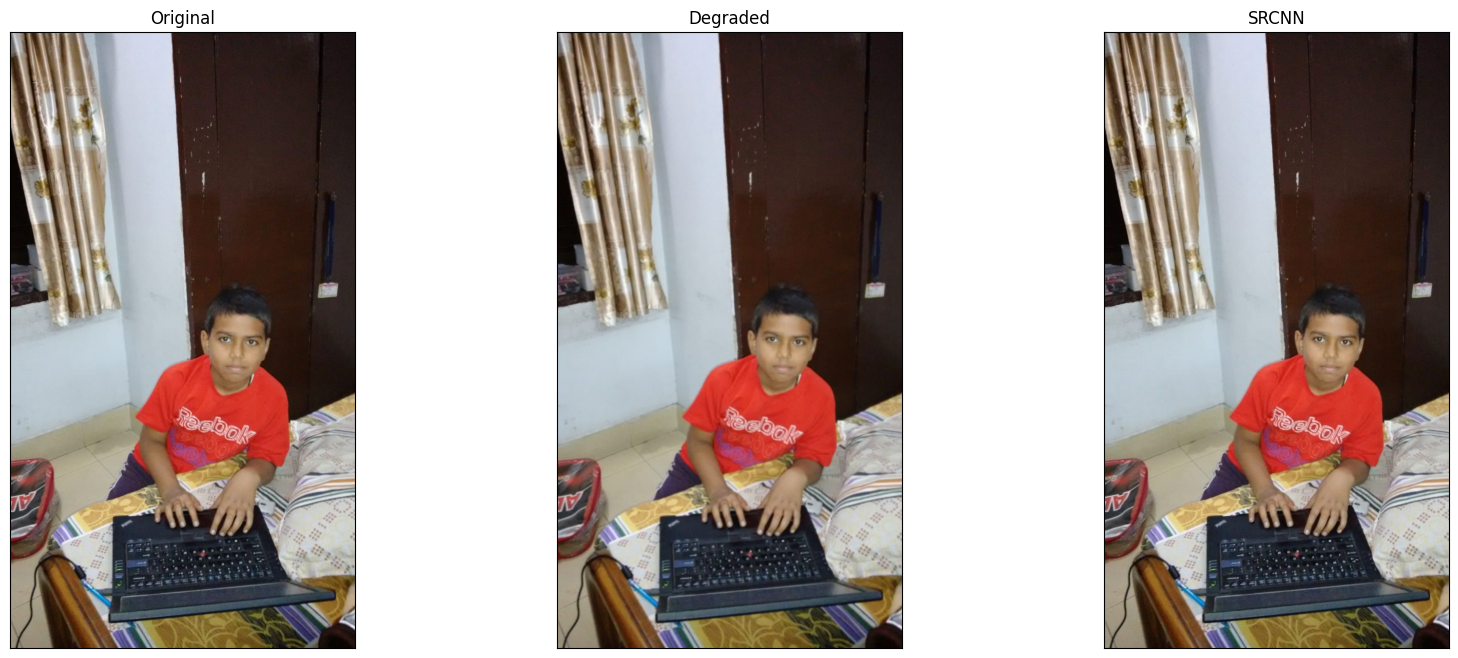

In [ ]:
# Image Processing Functions
def modcrop(img, scale):
    """
    Crop the image so its dimensions are divisible by the scaling factor.
    """
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[:sz[0], :sz[1]]
    return img

def shave(image, border):
    """
    Remove the border of the image by the specified width.
    """
    return image[border: -border, border: -border]

def compare_images(img1, img2):
    """
    Compare two images using PSNR, MSE, and a simplified SSIM approximation.
    """
    psnr = cv2.PSNR(img1, img2)
    mse = np.mean((img1 - img2) ** 2)
    ssim = 1 - mse / (np.var(img1) + np.var(img2) + mse)
    return psnr, mse, ssim

def model():
    """
    Define a simple SRCNN model structure.
    """
    from keras.layers import Conv2D
    from keras.optimizers import Adam

    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))

    adam = Adam(learning_rate=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

def predict(image_path):
    """
    Perform super-resolution on an input image using the SRCNN model.
    """
    srcnn = model()
    try:
        srcnn.load_weights('3051crop_weight_200.h5')
    except Exception as e:
        raise ValueError(f"Error loading weights: {e}")

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread(f'source/{file}')

    if degraded is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    if ref is None:
        raise FileNotFoundError(f"Reference image not found for: {file}")

    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    pre = srcnn.predict(Y, batch_size=1)

    pre *= 255
    pre[pre > 255] = 255
    pre[pre < 0] = 0
    pre = pre.astype(np.uint8)

    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    return ref, degraded, output, scores

image_path = 'images/Ankur_LR.jpg'
try:
    ref, degraded, output, scores = predict(image_path)

    print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
    print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Saving download.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Saving Ankur_LR.jpg


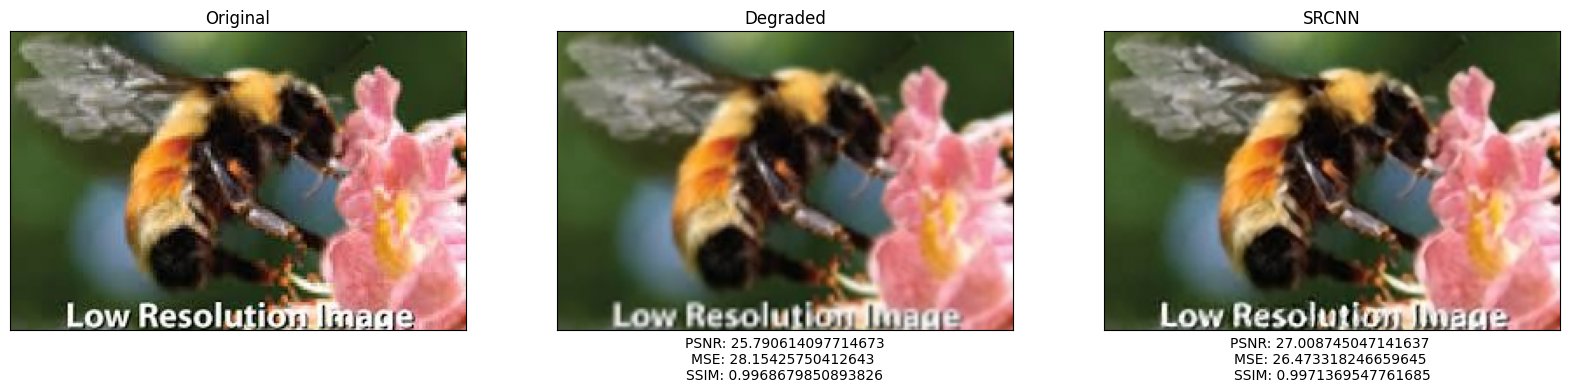

In [ ]:

for file in os.listdir('images'):
    # perform super-resolution
    try:
      ref, degraded, output, scores = predict('images/{}'.format(file))
    except:
      continue



    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))


    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0]))
plt.close()